# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from agent import Agent
from collections import deque
import time
import matplotlib.pyplot as plt
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
"""
for i in range(1, 15):                                     # play game for 14 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))
"""

"\nfor i in range(1, 15):                                     # play game for 14 episodes\n    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    \n    states = env_info.vector_observations                  # get the current state (for each agent)\n    scores = np.zeros(num_agents)                          # initialize the score (for each agent)\n    while True:\n        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)\n        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1\n        env_info = env.step(actions)[brain_name]           # send all actions to tne environment\n        next_states = env_info.vector_observations         # get next state (for each agent)\n        rewards = env_info.rewards                         # get reward (for each agent)\n        dones = env_info.local_done                        # see if episode finished\n        scores += env_info.rewards              

In [6]:
"""
#definition hyperparameters and trainingsconditions
n_episodes = 2000
max_noice= 1.0
noice_decay = 0.995
training_mode = True
random_seed = 0

#Initialize Feed-forward DNNs for Actor and Critic model 
agent = Agent(state_size*num_agents, action_size*num_agents, random_seed, max_noice, noice_decay)

current_best = 0
counter = 0
#train the agent
def ddpg_train(n_episodes):
    #list containing scores from each episode
    scores = []
    #list containing means over last 100 episodes
    means = []
    #last 100 scores
    scores_window = deque(maxlen = 100)
    # messure time for achieving a mean score over 30
    start_time = time.time()
    for episode in range(n_episodes):
        # messure time for one episode
        start_episode = time.time()
        # Reset the enviroment
        env_info = env.reset(train_mode=training_mode)[brain_name] 
        cur_states = env_info.vector_observations
        cur_states = np.reshape(cur_states,(1,state_size*num_agents))[0]
        print(cur_states)
        score = np.zeros(num_agents)
        # initialize timestep
        timestep = 0
        # reset noise
        agent.reset()
        while True:
            # Choose best action for given network
            actions = agent.act(cur_states, add_noise = True)
            actions = np.reshape(actions,(num_agents,int(len(actions)/num_agents)))
            # Action is performed and new state, reward, info are received. 
            env_info = env.step(actions)[brain_name]
            # get next state 
            next_states = env_info.vector_observations
            next_states = np.reshape(next_states,(1,state_size*num_agents))[0]
            # see if episode is finished
            dones = env_info.local_done
            # get reward
            rewards = env_info.rewards
            # save experience to replay buffer, perform learning step at defined interval
            # current state, action, reward, new state are stored in the experience replay
            agent.step(cur_states, actions, max(rewards), next_states, dones, timestep)
            # roll over new state
            cur_states = next_states      
            #add reward to score
            score += rewards
            # count timestep
            timestep+=1
            if np.any(dones):
                break
        #calculate time
        time_episode = time.time() - start_episode
        time_entire = time.time() - start_time
        #save most recent score
        scores_window.append(max(score))
        scores.append(max(score))
        mean = np.mean(scores_window)
        means.append(mean)
        if episode%100 == 0 & episode != 0:
            time_100_episodes = time.time() - start_episode
            print("Episode:" + str(episode) + " Score (max over all agents):" + str(max(score)) + 
                  " Mean Score(last 100 episodes):" + str(np.mean(scores_window)) +
                  " Duration last 100 episodes:" + time.strftime('%Mm%Ss', time.gmtime(time_100_episodes)) + 
                  " Duration training:" + time.strftime('%Hh%Mm%Ss', time.gmtime(time_entire)))
        
        #save model weights
        global current_best
        if current_best < np.mean(scores_window):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_Actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_Critic.pth')
            current_best = np.mean(scores_window)
            if np.mean(scores_window) >= 0.5 and counter == 0:
                print("Environment solved in " + str(episode) + " episodes. Mean score over all 20 agents " +
                      str(np.mean(scores_window)) + " for the last 100 episodes")
                counter = 1
    return scores, means

scores, means = ddpg_train(n_episodes)

# last save
torch.save(agent.actor_local.state_dict(), 'end_weight_Actor.pth')
torch.save(agent.critic_local.state_dict(), 'end_weight_Critic.pth')

episode_scores = []
for record in scores:
    episode_scores.append(np.mean(record))

#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(episode_scores)), episode_scores, label = "score")
plt.plot(np.arange(len(means)), means, label = "mean")
plt.axhline(y=0.5, color='r', linestyle='--', label="target")
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend()
plt.show()
"""

'\n#definition hyperparameters and trainingsconditions\nn_episodes = 2000\nmax_noice= 1.0\nnoice_decay = 0.995\ntraining_mode = True\nrandom_seed = 0\n\n#Initialize Feed-forward DNNs for Actor and Critic model \nagent = Agent(state_size*num_agents, action_size*num_agents, random_seed, max_noice, noice_decay)\n\ncurrent_best = 0\ncounter = 0\n#train the agent\ndef ddpg_train(n_episodes):\n    #list containing scores from each episode\n    scores = []\n    #list containing means over last 100 episodes\n    means = []\n    #last 100 scores\n    scores_window = deque(maxlen = 100)\n    # messure time for achieving a mean score over 30\n    start_time = time.time()\n    for episode in range(n_episodes):\n        # messure time for one episode\n        start_episode = time.time()\n        # Reset the enviroment\n        env_info = env.reset(train_mode=training_mode)[brain_name] \n        cur_states = env_info.vector_observations\n        cur_states = np.reshape(cur_states,(1,state_size*num_a

In [7]:
"""
#definition hyperparameters and trainingsconditions
n_episodes = 20000
max_noice= 1.0
noice_decay = 0.995
training_mode = True
random_seed = 0

#Initialize Feed-forward DNNs for Actor and Critic model 
agent1 = Agent(state_size, action_size, random_seed, max_noice, noice_decay)
agent2 = Agent(state_size, action_size, random_seed, max_noice, noice_decay)

current_best = 0
counter = 0
#train the agent
def ddpg_train(n_episodes):
    #list containing scores from each episode
    scores = []
    #list containing means over last 100 episodes
    means = []
    #last 100 scores
    scores_window = deque(maxlen = 100)
    # messure time for achieving a mean score over 30
    start_time = time.time()
    for episode in range(n_episodes):
        # messure time for one episode
        start_episode = time.time()
        # Reset the enviroment
        env_info = env.reset(train_mode=training_mode)[brain_name] 
        cur_states = env_info.vector_observations
        # get scores
        score = np.zeros(num_agents)
        # initialize timestep
        timestep = 0
        # reset noise
        agent1.reset()
        agent2.reset()
        while True:
            # Choose best action for given network
            actions = np.array([[0,0],[0,0]])
            actions[0] = agent1.act(cur_states[0], add_noise = True)
            actions[1] = agent2.act(cur_states[1], add_noise = True)
            # Action is performed and new state, reward, info are received. 
            env_info = env.step(actions)[brain_name]
            # get next state 
            next_states = env_info.vector_observations
            # see if episode is finished
            dones = env_info.local_done
            # get reward
            rewards = env_info.rewards
            # save experience to replay buffer, perform learning step at defined interval
            # current state, action, reward, new state are stored in the experience replay
            agent1.step(cur_states[0], actions[0], rewards[0], next_states[0], dones[0], timestep)
            agent2.step(cur_states[1], actions[1], rewards[1], next_states[1], dones[1], timestep)
            # roll over new state
            cur_states = next_states      
            #add reward to score
            score += rewards
            # count timestep
            timestep+=1
            if np.any(dones):
                break
        #calculate time
        time_episode = time.time() - start_episode
        time_entire = time.time() - start_time
        #save most recent score
        scores_window.append(max(score))
        scores.append(max(score))
        mean = np.mean(scores_window)
        means.append(mean)
        if episode%100 == 0 and episode != 0:
            time_100_episodes = time.time() - start_episode
            print("Episode:" + str(episode) + " Score (max over all agents):" + str(max(score)) + 
                    " Mean Score(last 100 episodes):" + str(np.mean(scores_window)) +
                    " Duration last episode:" + time.strftime('%Mm%Ss', time.gmtime(time_100_episodes)) + 
                    " Duration training:" + time.strftime('%Hh%Mm%Ss', time.gmtime(time_entire)))
        
        #save model weights
        global current_best
        if current_best < np.mean(scores_window):
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_Actor_1.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_Critic_1.pth')
            torch.save(agent1.actor_local.state_dict(), 'checkpoint_Actor_2.pth')
            torch.save(agent1.critic_local.state_dict(), 'checkpoint_Critic_2.pth')
            current_best = np.mean(scores_window)
            if np.mean(scores_window) >= 0.5 and counter == 0:
                print("Environment solved in " + str(episode) + " episodes. Mean score over all 20 agents " +
                      str(np.mean(scores_window)) + " for the last 100 episodes")
                counter = 1
    return scores, means

scores, means = ddpg_train(n_episodes)

# last save
torch.save(agent1.actor_local.state_dict(), 'end_weight_Actor_1.pth')
torch.save(agent1.critic_local.state_dict(), 'end_weight_Critic_1.pth')
torch.save(agent2.actor_local.state_dict(), 'end_weight_Actor_2.pth')
torch.save(agent2.critic_local.state_dict(), 'end_weight_Critic_2.pth')

episode_scores = []
for record in scores:
    episode_scores.append(np.mean(record))

#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(episode_scores)), episode_scores, label = "score")
plt.plot(np.arange(len(means)), means, label = "mean")
plt.axhline(y=0.5, color='r', linestyle='--', label="target")
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend()
plt.show()
"""

'\n#definition hyperparameters and trainingsconditions\nn_episodes = 20000\nmax_noice= 1.0\nnoice_decay = 0.995\ntraining_mode = True\nrandom_seed = 0\n\n#Initialize Feed-forward DNNs for Actor and Critic model \nagent1 = Agent(state_size, action_size, random_seed, max_noice, noice_decay)\nagent2 = Agent(state_size, action_size, random_seed, max_noice, noice_decay)\n\ncurrent_best = 0\ncounter = 0\n#train the agent\ndef ddpg_train(n_episodes):\n    #list containing scores from each episode\n    scores = []\n    #list containing means over last 100 episodes\n    means = []\n    #last 100 scores\n    scores_window = deque(maxlen = 100)\n    # messure time for achieving a mean score over 30\n    start_time = time.time()\n    for episode in range(n_episodes):\n        # messure time for one episode\n        start_episode = time.time()\n        # Reset the enviroment\n        env_info = env.reset(train_mode=training_mode)[brain_name] \n        cur_states = env_info.vector_observations\n    

In [8]:
"""
#definition hyperparameters and trainingsconditions
n_episodes = 10000
noice= 1.0
noice_decay = 0.999
min_noice = 0.01
training_mode = True
max_t = 1000
random_seed = 1
random_episodes = 100

#help variables
#boolean if task is allready fullfilled
ready = False
#current best mean score during training
current_best = 0

#create a new agent
agent = Agent(state_size = state_size, action_size = action_size, random_seed = random_seed)

def maddpg_train(n_episodes, max_t):
    #list containing scores from each episode
    scores = []
    #list containing means over last 100 episodes
    means = []
    #last 100 scores
    scores_window = deque(maxlen = 100)
    #messure duration of training
    start_time = time.time()
    #messure time for 100 episodes
    start_100_episodes = time.time()
    for i_episode in range(1, n_episodes+1):
        #reset the enviroment
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        e_scores = np.zeros(2)
        agent.reset()
        # initialize timestep
        timestep = 0
        for i in range(max_t):
            #choose best action for given network
            #choose random actions at beginning to get some interaction with the environment
            if i_episode < random_episodes:
                actions = np.random.randn(2, 2)
            else:
                actions = agent.act(states, noise_factor = noice)
            #actions of the second player as fliped network actions
            actions_second_player = np.flip(actions, 0)
            #action is performed and new state, reward, info are received. 
            env_info = env.step(actions)[brain_name]            
            #see if episode has finished
            dones = env_info.local_done                          
            # get next state 
            next_states = env_info.vector_observations         
            next_states_second_player = np.flip(next_states, 0)
            #get rewards
            rewards = env_info.rewards
            #save experience to replay buffer, perform learning step at defined interval
            #current state, action, reward, new state are stored in the experience replay
            agent.step(states, actions, actions_second_player, rewards, next_states, next_states_second_player, dones, timestep)
            #roll over the states
            states = next_states
            #add reward to episode score
            e_scores += rewards
            # count timestep
            timestep+=1
            if np.any(dones):
                break      
        #calculate time
        time_100_episodes = time.time() - start_100_episodes
        time_entire = time.time() - start_time
        #save most recent score
        scores_window.append(np.max(e_scores))
        scores.append(np.max(e_scores))
        mean = np.mean(scores_window)
        means.append(mean)
        if i_episode%100 == 0:
            print("Episode:\t\t\t" + str(i_episode) +
                  "\nMean Score(last 100 episodes):\t" + str(np.mean(scores_window)) +
                  "\nDuration last 100 episodes:\t" + time.strftime('%Mm%Ss', time.gmtime(time_100_episodes)) + 
                  "\nDuration training:\t\t" + time.strftime('%Hh%Mm%Ss', time.gmtime(time_entire)) + "\n")
            #reset start time 100 episodes
            start_100_episodes = time.time()
        #save model weights
        global current_best
        if current_best < np.mean(scores_window):
            torch.save(agent.actor_local.state_dict(), 'checkpoint_Actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_Critic.pth')
            current_best = np.mean(scores_window)
            if np.mean(scores_window) >= 0.5 and ready == False:
                print("Environment solved in " + str(i_episode) + " episodes. Mean score over all 20 agents " +
                      str(np.mean(scores_window)) + " for the last 100 episodes")
                ready = True
    return scores, means

scores, means = maddpg_train(n_episodes, max_t)

# last save
torch.save(agent.actor_local.state_dict(), 'end_weight_Actor.pth')
torch.save(agent.critic_local.state_dict(), 'end_weight_Critic.pth')

episode_scores = []
for record in scores:
    episode_scores.append(np.mean(record))

#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(episode_scores)), episode_scores, label = "score")
plt.plot(np.arange(len(means)), means, label = "mean")
plt.axhline(y=0.5, color='r', linestyle='--', label="target")
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend()
plt.show()
"""

'\n#definition hyperparameters and trainingsconditions\nn_episodes = 10000\nnoice= 1.0\nnoice_decay = 0.999\nmin_noice = 0.01\ntraining_mode = True\nmax_t = 1000\nrandom_seed = 1\nrandom_episodes = 100\n\n#help variables\n#boolean if task is allready fullfilled\nready = False\n#current best mean score during training\ncurrent_best = 0\n\n#create a new agent\nagent = Agent(state_size = state_size, action_size = action_size, random_seed = random_seed)\n\ndef maddpg_train(n_episodes, max_t):\n    #list containing scores from each episode\n    scores = []\n    #list containing means over last 100 episodes\n    means = []\n    #last 100 scores\n    scores_window = deque(maxlen = 100)\n    #messure duration of training\n    start_time = time.time()\n    #messure time for 100 episodes\n    start_100_episodes = time.time()\n    for i_episode in range(1, n_episodes+1):\n        #reset the enviroment\n        env_info = env.reset(train_mode=True)[brain_name]\n        states = env_info.vector_obs

Episode: 100	Current Score: 0.0	Mean over 10 episodes: 0.0	Mean over 100 episodes: 0.01513
Environment solved in 101 episodes. Max score: 0.015 for the last 100 episodesdes: 0.015


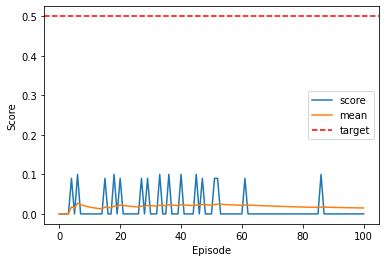

In [9]:
min_noise = 0.1
noise_decay = 0.999
noise_factor = 1.0
random_seed = 1
random_episodes = 100
max_episodes = 5000
max_t = 10000

#variable to safe the best net
current_best = 0
#boolean to show if task is fullfilled
ready = False

# create a new agent
agent = Agent(state_size = state_size, action_size=action_size, random_seed=random_seed)

def maddpg(n_episodes, max_t):
    scores_window = deque(maxlen=100)
    scores = []
    means = []
    noise_f = noise_factor
    for episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        #get the current states
        states = env_info.vector_observations
        #initialize score for one episode
        e_scores = np.zeros(2)
        #reset the agent
        agent.reset()
        #set the timestep
        timestep=0
        for t in range(max_t):
            #use random actions the first few episodes to collect some information about the environment
            if episode < random_episodes:
                actions = np.random.randn(2, 2)
            #select actions according to the agents networks
            else:
                actions = agent.act(states, noise_factor=noise_f)
            actions_second_player = np.flip(actions, 0)
            #execute the actions
            env_info = env.step(actions)[brain_name] 
            #get the next_states, rewards and informations if episode has finished
            rewards = env_info.rewards
            next_states = env_info.vector_observations
            next_states_second_player = np.flip(next_states, 0)
            dones = env_info.local_done
            agent.step(states, actions, actions_second_player, rewards, next_states, next_states_second_player, dones, timestep)  # pass the information to the agent
            #roll over the states
            states = next_states
            #add the reward to the score
            e_scores += rewards
            #count the timestep
            timestep+=1
            if np.any(dones):
                break
        #get the maximum score of both agents
        max_score = np.max(e_scores)
        scores_window.append(max_score)
        scores.append(max_score)
        means.append(np.mean(scores_window))
        #reduce the noise
        noise_f = max(noise_decay * noise_f, min_noise)
        print("Episode: " + str(episode) + "\tCurrent Score: " + str(round(max_score,3)) + 
              "\tMean over 10 episodes: " + str(round(np.mean(list(scores_window)[-10:]),3)) +
              "\tMean over 100 episodes: " + str(round(np.mean(scores_window),3)), end = "\r")
        #print('\rEpisode {:d}\tmax score: {:.2f}\taverage maximum score over the last 10 episodes: {:.2f}'.format(episode, scores_window[-1], np.mean(list(scores_window)[-10:])), end="")
        global current_best
        global ready
        if episode > 100 and np.mean(scores_window) > current_best:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_Actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_Critic.pth')
            current_best = np.mean(scores_window)
            if np.mean(scores_window) >= 0.5 and ready == False:
                print("Environment solved in " + str(episode) + " episodes. Max score: " +
                      str(round(np.mean(scores_window),3)) + " for the last 100 episodes")
                ready = True
                break;
        if episode % 100 == 0:
            print("Episode: " + str(episode) + "\tCurrent Score: " + str(round(max_score,3)) + 
              "\tMean over 10 episodes: " + str(round(np.mean(list(scores_window)[-10:]),3)) +
              "\tMean over 100 episodes: " + str(round(np.mean(scores_window),3)))
            #print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
            
    return scores, means

scores, means = maddpg(max_episodes, max_t)

#last save
torch.save(agent.actor_local.state_dict(), 'end_weight_Actor.pth')
torch.save(agent.critic_local.state_dict(), 'end_weight_Critic.pth')

episode_scores = []
for record in scores:
    episode_scores.append(np.mean(record))

#plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(episode_scores)), episode_scores, label = "score")
plt.plot(np.arange(len(means)), means, label = "mean")
plt.axhline(y=0.5, color='r', linestyle='--', label="target")
plt.ylabel('Score')
plt.xlabel('Episode')
plt.legend()
plt.show()

In [10]:
"""
# create a new agent
agent = Agent(state_size = state_size, action_size=2, random_seed=1)

def maddpg(n_episodes=20000, max_t=10000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    beta = 1.0  # factor the random noise gets multiplied with
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations  # get the current states
        e_scores = np.zeros(2)  # the scores of an episode for both tennis agents
        agent.reset()
        timestep=0
        for t in range(max_t):
            if i_episode < 100:
                actions = np.random.randn(2, 2)  # use random actions for the first 100 episodes
            else:
                actions = agent.act(states, noise_factor=beta)  # let the agent select actions
            actions_other_player = np.flip(actions, 0)          # The actions of the other player
            env_info = env.step(actions)[brain_name]            # execute the selected actions and save the new information about the environment
            rewards = env_info.rewards                          # get the rewards
            next_states = env_info.vector_observations          # get the resulting states
            next_states_other_player = np.flip(next_states, 0)  # get the resulting states for the other player
            dones = env_info.local_done                         # check whether episodes have finished
            agent.step(states, actions, actions_other_player, rewards, next_states, next_states_other_player, dones, timestep)  # pass the information to the agent
            states = next_states
            e_scores += rewards
            timestep+=1
            if np.any(dones):
                break
        max_score = np.max(e_scores)  # the max score of the agents
        scores_deque.append(max_score)
        scores.append(max_score)
        beta = max(0.999 * beta, 0.01)  # reduce the noise a bit while training
        print('\rEpisode {:d}\tmax score: {:.2f}\taverage maximum score over the last 10 episodes: {:.2f}'.format(i_episode, scores_deque[-1], np.mean(list(scores_deque)[-10:])), end="")
        if i_episode % 250 == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_Actor.pth'.format(i_episode, scores_deque[-1]))
            torch.save(agent.critic_local.state_dict(), 'checkpoint_Critic.pth'.format(i_episode, scores_deque[-1]))
        if i_episode > 100 and np.mean(scores_deque) > 0.5:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_Actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_Critic.pth')
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_deque)))
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
            
    return scores

scores = maddpg()



fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()
"""

'\n# create a new agent\nagent = Agent(state_size = state_size, action_size=2, random_seed=1)\n\ndef maddpg(n_episodes=20000, max_t=10000, print_every=100):\n    scores_deque = deque(maxlen=print_every)\n    scores = []\n    beta = 1.0  # factor the random noise gets multiplied with\n    for i_episode in range(1, n_episodes+1):\n        env_info = env.reset(train_mode=True)[brain_name]\n        states = env_info.vector_observations  # get the current states\n        e_scores = np.zeros(2)  # the scores of an episode for both tennis agents\n        agent.reset()\n        timestep=0\n        for t in range(max_t):\n            if i_episode < 100:\n                actions = np.random.randn(2, 2)  # use random actions for the first 100 episodes\n            else:\n                actions = agent.act(states, noise_factor=beta)  # let the agent select actions\n            actions_other_player = np.flip(actions, 0)          # The actions of the other player\n            env_info = env.step(ac

When finished, you can close the environment.

In [11]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```